In [1]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer import MCMC, NUTS
import pyro.distributions as dist
from time import time
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def test(model, guide, param_name, args, tol=1e-2, warmup=100, max_iter=10000, delta=100):
    
    res = {}
    
    for lr in [0.01, 0.005, 0.001]:
        
        pyro.clear_param_store()
        
        # Optimizer and SVI setup
        optimizer = Adam({'lr':lr})
        
        svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

        # Training loop
        start = time()
        n_steps = 0
        for i in range(warmup):
            svi.step(*args)
            n_steps += 1
        while(n_steps < max_iter):
            # Take a gradient step
            old_param = pyro.param(param_name+'_map').item()
            
            for _ in range(delta):
                svi.step(*args)
                n_steps += 1
            new_param = pyro.param(param_name+'_map').item()
            #if n_steps % 100 == 0:
                #print('{} steps'.format(n_steps))
            if abs(old_param - new_param) < tol*abs(new_param):
                break
        end = time()
        
        res[lr] = new_param
        
        print('Learning rate: ', lr)
        print('Performed {} steps'.format(n_steps))
        print('Computed in:', np.round(end-start,3))
        print('Estimated value:', new_param)
        print('________________________________')
        
    return res

def mcmc(model, name_param, args, num_samples=1000, plot=True, plot_title='', MAP=True, mean=True):
    
    nuts_kernel = NUTS(model)
    mcmc_run = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=500)
    mcmc_run.run(*args)
    mcmc_samples = mcmc_run.get_samples()

    mcmc_samples = mcmc_samples[name_param].detach().numpy()
    np.savetxt('Samples/'+plot_title+'MCMC.csv', mcmc_samples, delimiter=',')
    
    if plot:
        _ = plt.hist(mcmc_samples, bins=50, density=True)
        plt.title(plot_title)
        plt.savefig('Densities/'+plot_title+'.png')
    
    if MAP:
        nums, ints = np.histogram(mcmc_samples, 100)
        max_num = max(nums)
        idx = list(nums).index(max_num)  
        print('MAP value in:', ints[idx], ints[idx+1])
        
    if mean:
        print('Mean value:', np.mean(mcmc_samples))
        
    return mcmc_samples

# Bernoulli

STAN: 0.20

In [ ]:
pyro.clear_param_store()

# Data
N =  10 # Set your value of N here
y_data =  torch.tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]) # Provide the array of observed values y here

# Define the model
def model(N, y):
    # Prior for theta
    theta = pyro.sample("theta", dist.Uniform(0,1))

    # Likelihood
    with pyro.plate("data_plate", N):
        y = pyro.sample("y", dist.Bernoulli(theta), obs=y)
        
mcmc_samples = mcmc(model, 'theta', args=(N,y_data), num_samples=10000, plot_title='Bernoulli')

Sample:   5%|█▉                                     | 524/10500 [00:05, 91.68it/s, step size=1.02e+00, acc. prob=0.932]

In [3]:
pyro.clear_param_store()

# Data
N =  10 # Set your value of N here
y_data =  torch.tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]) # Provide the array of observed values y here

# Define the model
def model(N, y):
    # Prior for theta
    theta = pyro.sample("theta", dist.Uniform(0,1))

    # Likelihood
    with pyro.plate("data_plate", N):
        y = pyro.sample("y", dist.Bernoulli(theta), obs=y)

# Define the guide (variational distribution)
def guide(N, y):
    # Variational parameter for theta
    #alpha_theta = pyro.param('alpha_theta', torch.tensor(1.), constraint=constraints.positive)
    #beta_theta = pyro.param('beta_theta', torch.tensor(1.), constraint=constraints.positive)
    #theta = pyro.sample('theta', dist.Beta(alpha_theta, beta_theta))
    theta_map = pyro.param('theta_map', torch.tensor(0.5))
    pyro.sample("theta", dist.Delta(theta_map))


test(model, guide, 'theta', args=(N,y_data))

Learning rate:  0.01
Performed 200 steps
Computed in: 0.197
Estimated value: 0.19999243319034576
________________________________
Learning rate:  0.005
Performed 200 steps
Computed in: 0.204
Estimated value: 0.1999809741973877
________________________________
Learning rate:  0.001
Performed 800 steps
Computed in: 0.827
Estimated value: 0.2001093178987503
________________________________


{0.01: 0.19999243319034576,
 0.005: 0.1999809741973877,
 0.001: 0.2001093178987503}

# BayesPointMachine

STAN: 0

Sample: 100%|█████████████████████████████████████| 10500/10500 [49:51,  3.51it/s, step size=3.33e-02, acc. prob=0.883]


MAP value in: 0.018931784 0.020732988
Mean value: 0.050425764


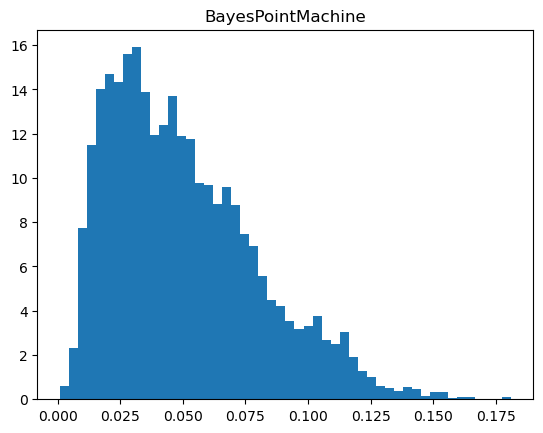

In [13]:
pyro.clear_param_store()

# Data
N =  6 # Set your value of N here
feat1 = torch.tensor([63.0., 16., 28., 55., 22., 20.]) # Provide the array of feat1 values here
feat2 =  torch.tensor([38., 23., 49., 27., 18., 40.])# Provide the array of feat2 values here
feat3 =  torch.tensor([1., 1., 1., 1., 1., 1.]) # Provide the array of feat3 values here
obs = torch.tensor([1., 0., 1., 1., 0., 0.]) # Provide the array of observed values here

# Define the model
def model(N, feat1, feat2, feat3, obs):
    
    w1 = pyro.sample("w1", dist.Normal(torch.tensor(0.), torch.tensor(1.)))  # Prior for weights w
    w2 = pyro.sample("w2", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    w3 = pyro.sample("w3", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    
    for i in pyro.plate("norm_plate", N):
        norm = pyro.sample("norm{}".format(i), dist.Normal(feat1[i]*w1 + feat2[i]*w2 + feat3[i]*w3, 0.1))
        constraint = (norm > 0).float()
        pyro.sample('obs{}'.format(i), dist.Delta(constraint), obs=obs[i])

mcmc_samples = mcmc(model, 'w1', args=(N,feat1,feat2,feat3,obs), num_samples=10000, plot_title='BayesPointMachine')

In [4]:
pyro.clear_param_store()

# Data
N =  6 # Set your value of N here
feat1 = torch.tensor([63., 16., 28., 55., 22., 20.]) # Provide the array of feat1 values here
feat2 =  torch.tensor([38., 23., 49., 27., 18., 40.])# Provide the array of feat2 values here
feat3 =  torch.tensor([1., 1., 1., 1., 1., 1.]) # Provide the array of feat3 values here
obs = torch.tensor([1., 0., 1., 1., 0., 0.]) # Provide the array of observed values here

# Define the model
def model(N, feat1, feat2, feat3, obs):
    
    w1 = pyro.sample("w1", dist.Normal(torch.tensor(0.), torch.tensor(1.)))  # Prior for weights w
    w2 = pyro.sample("w2", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    w3 = pyro.sample("w3", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    
    for i in pyro.plate("norm_plate", N):
        norm = pyro.sample("norm{}".format(i), dist.Normal(feat1[i]*w1 + feat2[i]*w2 + feat3[i]*w3, 0.1))
        constraint = (norm > 0).float()
        pyro.sample('obs{}'.format(i), dist.Delta(constraint), obs=obs[i])


# Define the guide (variational distribution)
def guide(N, feat1, feat2, feat3, obs):
        
    # Variational parameters for weights w
    w1_map = pyro.param("w1_map", torch.tensor(0.))
    w1 = pyro.sample("w1", dist.Delta(w1_map))
    
    #w2_loc = pyro.param("w2_loc", torch.tensor(0.))
    #w2_scale = pyro.param("w2_scale", torch.tensor(1.), constraint=dist.constraints.positive)
    w2 = pyro.sample("w2", dist.Normal(0., 1.))
    
    #w3_loc = pyro.param("w3_loc", torch.tensor(0.))
    #w3_scale = pyro.param("w3_scale", torch.tensor(1.), constraint=dist.constraints.positive)
    w3 = pyro.sample("w3", dist.Normal(0., 1.))
    
    # Variational parameters for norms
    for i in pyro.plate("norm_plate",N):
        norm = pyro.sample("norm{}".format(i), dist.Normal(feat1[i]*w1 + feat2[i]*w2 + feat3[i]*w3, 0.1))
        constraint = (norm > 0).float()
    
    
test(model, guide, 'w1', args=(N, feat1, feat2, feat3, obs))

Learning rate:  0.01
Performed 900 steps
Computed in: 7.831
Estimated value: 0.0005423434777185321
________________________________
Learning rate:  0.005
Performed 10000 steps
Computed in: 87.737
Estimated value: -0.00031775125535205007
________________________________
Learning rate:  0.001
Performed 10000 steps
Computed in: 86.176
Estimated value: 4.835394429392181e-05
________________________________


{0.01: 0.0005423434777185321,
 0.005: -0.00031775125535205007,
 0.001: 4.835394429392181e-05}

# ClickGraph

STAN 0.67

Sample: 100%|█████████████████████████████████████| 10500/10500 [27:11,  6.43it/s, step size=6.43e-01, acc. prob=0.856]


MAP value in: 0.98997504 0.999972
Mean value: 0.61240584


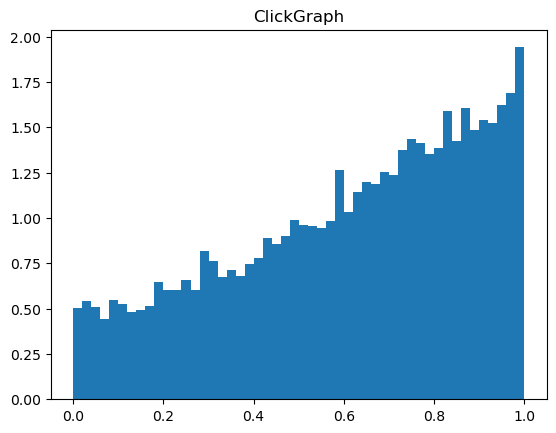

In [15]:
pyro.clear_param_store()

N = 5
click0 = torch.tensor([1.,1.,1.,0.,0.])
click1 = torch.tensor([1.,1.,1.,0.,0.])

# Define the model in Pyro
def model(N, click0, click1):
    simAll = pyro.sample("simAll", dist.Uniform(0, 1))

    for i in pyro.plate('data', N):
        branch = pyro.sample("branch{}".format(i), dist.Bernoulli(simAll))
        beta1 = pyro.sample("beta1{}".format(i), dist.Uniform(0., 1.))
        beta2 = pyro.sample("beta2{}".format(i), dist.Uniform(0., 1.))
        click_probs = torch.where(branch.bool(), beta1, beta2)  # Select probabilities based on branch values
        pyro.sample("click0{}".format(i), dist.Bernoulli(beta1), obs=click0[i])
        pyro.sample("click1{}".format(i), dist.Bernoulli(click_probs), obs=click1[i])
        
mcmc_samples = mcmc(model, 'simAll', args=(N,click0,click1), num_samples=10000, plot_title='ClickGraph')

In [5]:
pyro.clear_param_store()

N = 5
click0 = torch.tensor([1.,1.,1.,0.,0.])
click1 = torch.tensor([1.,1.,1.,0.,0.])

# Define the model in Pyro
def model(N, click0, click1):
    simAll = pyro.sample("simAll", dist.Uniform(0, 1))

    for i in pyro.plate('data', N):
        branch = pyro.sample("branch{}".format(i), dist.Bernoulli(simAll))
        beta1 = pyro.sample("beta1{}".format(i), dist.Uniform(0., 1.))
        beta2 = pyro.sample("beta2{}".format(i), dist.Uniform(0., 1.))
        click_probs = torch.where(branch.bool(), beta1, beta2)  # Select probabilities based on branch values
        pyro.sample("click0{}".format(i), dist.Bernoulli(beta1), obs=click0[i])
        pyro.sample("click1{}".format(i), dist.Bernoulli(click_probs), obs=click1[i])

# Define the guide (variational distribution) in Pyro
def guide(N, click0, click1):
    
    simAll_map = pyro.param('simAll_map', torch.tensor(0.5), constraint=constraints.unit_interval)
    simAll = pyro.sample("simAll", dist.Delta(simAll_map))
    
    for i in pyro.plate("data", N):
        branch = pyro.sample("branch{}".format(i), dist.Bernoulli(simAll))
        
        beta1 = pyro.sample("beta1{}".format(i), dist.Uniform(0.,1.))
        beta2 = pyro.sample("beta2{}".format(i), dist.Uniform(0.,1.))
        
        click_probs = torch.where(branch.bool(), beta1, beta2)
    
    
test(model, guide, 'simAll', args=(N, click0, click1))

Learning rate:  0.01
Performed 700 steps
Computed in: 9.506
Estimated value: 0.41696450114250183
________________________________
Learning rate:  0.005
Performed 300 steps
Computed in: 4.227
Estimated value: 0.49017035961151123
________________________________
Learning rate:  0.001
Performed 200 steps
Computed in: 2.981
Estimated value: 0.5012288093566895
________________________________


{0.01: 0.41696450114250183,
 0.005: 0.49017035961151123,
 0.001: 0.5012288093566895}

# CoinBias

Sample: 100%|████████████████████████████████████| 10500/10500 [01:08, 154.33it/s, step size=1.17e+00, acc. prob=0.886]


MAP value in: 0.38964343 0.39804745
Mean value: 0.41601408


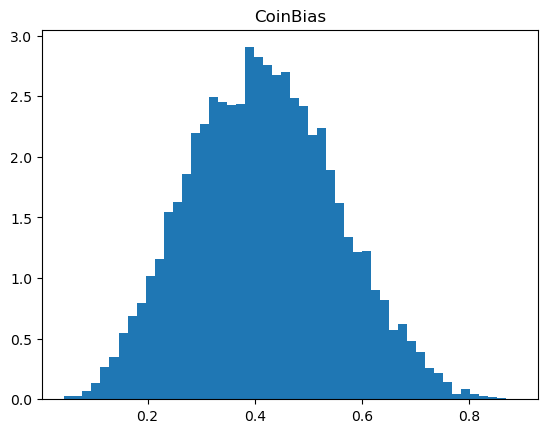

In [17]:
pyro.clear_param_store()

data = [torch.tensor(1.),
       torch.tensor(1.),
       torch.tensor(0.),
       torch.tensor(1.),
       torch.tensor(0.)]

def model(data):
    # sample theta from uniform prior
    theta = pyro.sample("theta", dist.Beta(2,5))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the ernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(theta), obs=data[i])
        
mcmc_samples = mcmc(model, 'theta', args=(data,), num_samples=10000, plot_title='CoinBias')

In [6]:
pyro.clear_param_store()

data = [torch.tensor(1.),
       torch.tensor(1.),
       torch.tensor(0.),
       torch.tensor(1.),
       torch.tensor(0.)]

def model(data):
    # sample theta from uniform prior
    theta = pyro.sample("theta", dist.Beta(2,5))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the ernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(theta), obs=data[i])

def guide(data):
    theta_map = pyro.param('theta_map', torch.tensor(1/6))
    pyro.sample("theta", dist.Delta(theta_map))

test(model, guide, 'theta', args=(data,))

Learning rate:  0.01
Performed 200 steps
Computed in: 0.633
Estimated value: 0.40000057220458984
________________________________
Learning rate:  0.005
Performed 200 steps
Computed in: 0.653
Estimated value: 0.3999849259853363
________________________________
Learning rate:  0.001
Performed 700 steps
Computed in: 2.318
Estimated value: 0.3982037305831909
________________________________


{0.01: 0.40000057220458984,
 0.005: 0.3999849259853363,
 0.001: 0.3982037305831909}

# SurveyUnbias

Sample: 100%|█████████████████████████████████████| 10500/10500 [03:49, 45.69it/s, step size=5.68e-01, acc. prob=0.940]


MAP value in: 0.9824852 0.99121153
Mean value: 0.8028255


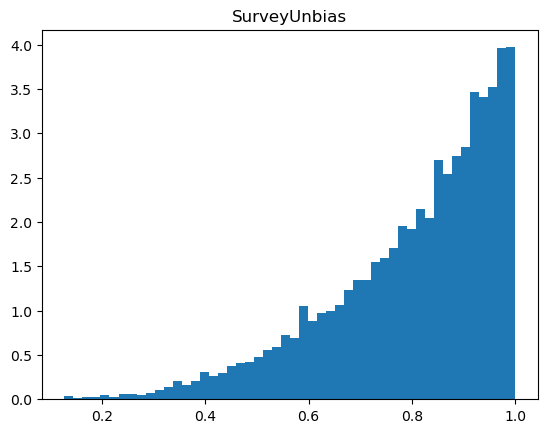

In [19]:
pyro.clear_param_store()

# Data
N = 5  
personGender = torch.tensor([0,1,0,0,1])  
dataAnswer = torch.tensor([1.,0.,1.,1.,1.])  # Assuming dataAnswer is 0 or 1 for each data point

# Pyro model
def model(N, personGender, dataAnswer):
    bias1 = pyro.sample("bias1", dist.Beta(torch.tensor(1.0), torch.tensor(1.0)))
    bias2 = pyro.sample("bias2", dist.Beta(torch.tensor(1.0), torch.tensor(1.0)))

    for n in pyro.plate("data", N):
        prob = torch.where(personGender[n].bool(), bias2, bias1)
        pyro.sample("dataAnswer_{}".format(n), dist.Bernoulli(prob), obs=dataAnswer[n])
        
mcmc_samples = mcmc(model, 'bias1', args=(N,personGender, dataAnswer), num_samples=10000, plot_title='SurveyUnbias')

In [7]:
pyro.clear_param_store()

# Data
N = 5  
personGender = torch.tensor([0,1,0,0,1])  
dataAnswer = torch.tensor([1.,0.,1.,1.,1.])  # Assuming dataAnswer is 0 or 1 for each data point

# Pyro model
def model(N, personGender, dataAnswer):
    bias1 = pyro.sample("bias1", dist.Beta(torch.tensor(1.0), torch.tensor(1.0)))
    bias2 = pyro.sample("bias2", dist.Beta(torch.tensor(1.0), torch.tensor(1.0)))

    for n in pyro.plate("data", N):
        prob = torch.where(personGender[n].bool(), bias2, bias1)
        pyro.sample("dataAnswer_{}".format(n), dist.Bernoulli(prob), obs=dataAnswer[n])
        
def guide(N, personGender, dataAnswer):
    
    bias1_map = pyro.param('bias1_map', torch.tensor(0.5), constraint=constraints.unit_interval)
    bias1 = pyro.sample("bias1", dist.Delta(bias1_map))
    
    bias2 = pyro.sample("bias2", dist.Beta(1.0, 1.0))

test(model, guide, 'bias1', args=(N, personGender, dataAnswer))

Learning rate:  0.01
Performed 700 steps
Computed in: 3.455
Estimated value: 0.964478075504303
________________________________
Learning rate:  0.005
Performed 1000 steps
Computed in: 4.881
Estimated value: 0.9429612755775452
________________________________
Learning rate:  0.001
Performed 2200 steps
Computed in: 11.533
Estimated value: 0.8471129536628723
________________________________


{0.01: 0.964478075504303, 0.005: 0.9429612755775452, 0.001: 0.8471129536628723}

# TrueSkills

Sample: 100%|█████████████████████████████████████| 10500/10500 [09:59, 17.52it/s, step size=2.00e-01, acc. prob=0.893]


MAP value in: 104.14383 104.82497
Mean value: 104.95736


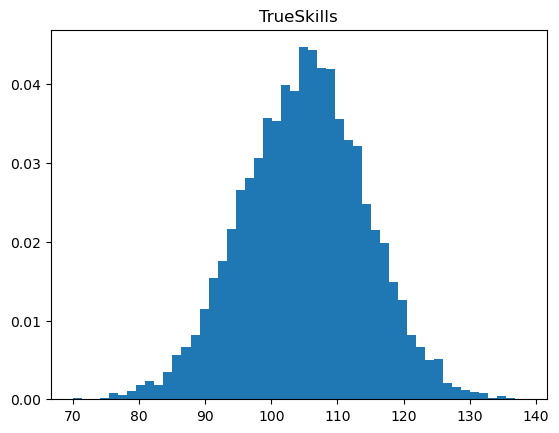

In [21]:
pyro.clear_param_store()

# Define the Pyro model
def model():
    skillA = pyro.sample("skillA", dist.Normal(100, 10))
    skillB = pyro.sample("skillB", dist.Normal(100, 10))
    skillC = pyro.sample("skillC", dist.Normal(100, 10))
    
    perfA = pyro.sample("perfA", dist.Normal(skillA, 15))
    perfB = pyro.sample("perfB", dist.Normal(skillB, 15)) 
    perfC = pyro.sample("perfC", dist.Normal(skillC, 15)) 
    
    pyro.sample("AbeatsB", dist.Bernoulli(logits=perfA - perfB), obs=torch.tensor(1.))
    pyro.sample("AbeatsC", dist.Bernoulli(logits=perfA - perfC), obs=torch.tensor(1.))
        
mcmc_samples = mcmc(model, 'skillA', args=(), num_samples=10000, plot_title='TrueSkills')

In [8]:
pyro.clear_param_store()

# Define the Pyro model
def model():
    skillA = pyro.sample("skillA", dist.Normal(100, 10))
    skillB = pyro.sample("skillB", dist.Normal(100, 10))
    skillC = pyro.sample("skillC", dist.Normal(100, 10))
    
    perfA = pyro.sample("perfA", dist.Normal(skillA, 15))
    perfB = pyro.sample("perfB", dist.Normal(skillB, 15)) 
    perfC = pyro.sample("perfC", dist.Normal(skillC, 15)) 
    
    pyro.sample("AbeatsB", dist.Bernoulli(logits=perfA - perfB), obs=torch.tensor(1.))
    pyro.sample("AbeatsC", dist.Bernoulli(logits=perfA - perfC), obs=torch.tensor(1.))
    
def guide():
    
    skillA_map = pyro.param('skillA_map', torch.tensor(100.))
    skillA = pyro.sample('skillA', dist.Delta(skillA_map))
    
    skillB = pyro.sample("skillB", dist.Normal(100, 10))
    skillC = pyro.sample("skillC", dist.Normal(100, 10))
    
    perfA = pyro.sample("perfA", dist.Normal(skillA, 15))
    perfB = pyro.sample("perfB", dist.Normal(skillB, 15)) 
    perfC = pyro.sample("perfC", dist.Normal(skillC, 15)) 

test(model, guide, 'skillA', args=())

Learning rate:  0.01
Performed 200 steps
Computed in: 0.992
Estimated value: 101.62904357910156
________________________________
Learning rate:  0.005
Performed 200 steps
Computed in: 0.974
Estimated value: 100.80146789550781
________________________________
Learning rate:  0.001
Performed 200 steps
Computed in: 1.029
Estimated value: 100.1552734375
________________________________


{0.01: 101.62904357910156, 0.005: 100.80146789550781, 0.001: 100.1552734375}

# Altermu

Sample: 100%|███████████████████████████████████| 10500/10500 [7:37:37,  2.62s/it, step size=1.22e-02, acc. prob=0.829]


MAP value in: 0.20664176 0.299102
Mean value: -0.20579731


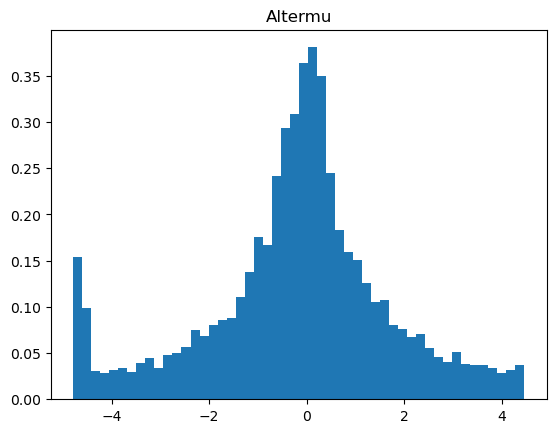

In [3]:
pyro.clear_param_store()

N = 40
y = torch.tensor([-2.57251482,  0.33806206,  2.71757796,  1.09861336,  2.85603752, -0.91651351,  0.15555127, -2.68160347,  2.47043789,  3.47459025, 1.63949862, -1.32148757,  2.64187513,  0.30357848, -4.09546231, -1.50709863, -0.99517866, -2.0648892 , -2.40317949,  3.46383544, 0.91173696,  1.18222221,  0.04235722, -0.52815171,  1.15551598, -1.62749724,  0.71473237, -1.08458812,  4.66020296,  1.24563831, -0.67970862,  0.93461681,  1.18187607, -1.49501051,  2.44755622, -2.06424237, -0.04584074,  1.93396696,  1.07685273, -0.09837907])

# Define the Pyro model
def model(N, y):
    mu1 = pyro.sample("mu1", dist.Normal(0.0, 5.0))
    mu2 = pyro.sample("mu2", dist.Normal(0.0, 5.0))
    mu3 = pyro.sample("mu3", dist.Normal(0.0, 5.0))
    
    for n in pyro.plate("data", N):
        pyro.sample("obs{}".format(n), dist.Normal(3*mu1*mu2-mu3, 1.0), obs=y[n])

mcmc_samples = mcmc(model, 'mu1', args=(N,y), num_samples=10000, plot_title='Altermu')

In [9]:
pyro.clear_param_store()

N = 40
y = torch.tensor([-2.57251482,  0.33806206,  2.71757796,  1.09861336,  2.85603752, -0.91651351,  0.15555127, -2.68160347,  2.47043789,  3.47459025, 1.63949862, -1.32148757,  2.64187513,  0.30357848, -4.09546231, -1.50709863, -0.99517866, -2.0648892 , -2.40317949,  3.46383544, 0.91173696,  1.18222221,  0.04235722, -0.52815171,  1.15551598, -1.62749724,  0.71473237, -1.08458812,  4.66020296,  1.24563831, -0.67970862,  0.93461681,  1.18187607, -1.49501051,  2.44755622, -2.06424237, -0.04584074,  1.93396696,  1.07685273, -0.09837907])

# Define the Pyro model
def model(N, y):
    mu1 = pyro.sample("mu1", dist.Normal(0.0, 5.0))
    mu2 = pyro.sample("mu2", dist.Normal(0.0, 5.0))
    mu3 = pyro.sample("mu3", dist.Normal(0.0, 5.0))
    
    for n in pyro.plate("data", N):
        pyro.sample("obs{}".format(n), dist.Normal(3*mu1*mu2-mu3, 1.0), obs=y[n])
        
def guide(N, y):
    
    mu1_map = pyro.param('mu1_map', torch.tensor(0.0))
    mu1 = pyro.sample('mu1', dist.Delta(mu1_map))
    
    mu2 = pyro.sample("mu2", dist.Normal(0.0, 5.0))
    mu3 = pyro.sample("mu3", dist.Normal(0.0, 5.0))
    
test(model, guide, 'mu1',  args=(N,y))

Learning rate:  0.01
Performed 10000 steps
Computed in: 190.628
Estimated value: -0.014561337418854237
________________________________
Learning rate:  0.005
Performed 10000 steps
Computed in: 184.589
Estimated value: 0.029260210692882538
________________________________
Learning rate:  0.001
Performed 10000 steps
Computed in: 185.757
Estimated value: 0.014976076781749725
________________________________


{0.01: -0.014561337418854237,
 0.005: 0.029260210692882538,
 0.001: 0.014976076781749725}

# Altermu2

Sample: 100%|███████████████████████████████████| 10500/10500 [2:02:24,  1.43it/s, step size=1.58e-02, acc. prob=0.953]


MAP value in: 6.8207145 7.0194087
Mean value: 0.41334298


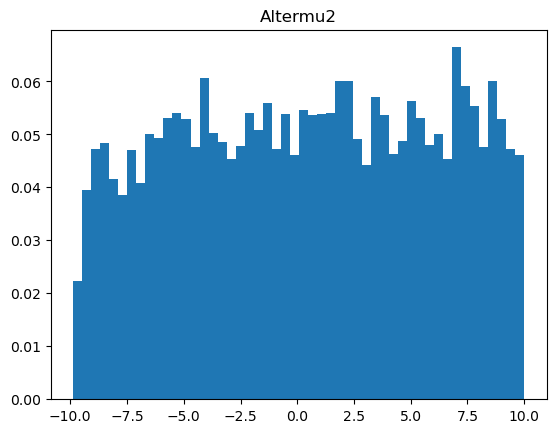

In [5]:
pyro.clear_param_store()

N = 40
y = torch.tensor([-2.57251482,  0.33806206,  2.71757796,  1.09861336,  2.85603752, -0.91651351,  0.15555127, -2.68160347,  2.47043789,  3.47459025, 1.63949862, -1.32148757,  2.64187513,  0.30357848, -4.09546231, -1.50709863, -0.99517866, -2.0648892 , -2.40317949,  3.46383544, 0.91173696,  1.18222221,  0.04235722, -0.52815171,  1.15551598, -1.62749724,  0.71473237, -1.08458812,  4.66020296,  1.24563831, -0.67970862,  0.93461681,  1.18187607, -1.49501051,  2.44755622, -2.06424237, -0.04584074,  1.93396696,  1.07685273, -0.09837907])


# Custom Beta distribution with support in [-10, 10]
from torch.distributions.transforms import SigmoidTransform, AffineTransform

class CustomBeta(dist.TransformedDistribution):
    def __init__(self, alpha, beta):
        base_dist = dist.Beta(alpha, beta)
        transforms = [AffineTransform(loc=-10, scale=20.0)]
        super().__init__(base_dist, transforms)


# Define the Pyro model
def model(N, y):
    mu1 = pyro.sample("mu1", dist.Uniform(-10.0, 10.0))
    mu2 = pyro.sample("mu2", dist.Uniform(-10.0, 10.0))
    
    for n in pyro.plate("data", N):
        pyro.sample("obs{}".format(n), dist.Normal(mu1+mu2, 1.0), obs=y[n])
        
mcmc_samples = mcmc(model, 'mu1', args=(N,y), num_samples=10000, plot_title='Altermu2')

In [11]:
#pyro.clear_param_store()
#
#N = 40
#y = torch.tensor([-2.57251482,  0.33806206,  2.71757796,  1.09861336,  2.85603752, -0.91651351,  0.15555127, -2.68160347,  2.47043789,  3.47459025, 1.63949862, -1.32148757,  2.64187513,  0.30357848, -4.09546231, -1.50709863, -0.99517866, -2.0648892 , -2.40317949,  3.46383544, 0.91173696,  1.18222221,  0.04235722, -0.52815171,  1.15551598, -1.62749724,  0.71473237, -1.08458812,  4.66020296,  1.24563831, -0.67970862,  0.93461681,  1.18187607, -1.49501051,  2.44755622, -2.06424237, -0.04584074,  1.93396696,  1.07685273, -0.09837907])
#
#
## Custom Beta distribution with support in [-10, 10]
#from torch.distributions.transforms import SigmoidTransform, AffineTransform
#
#class CustomBeta(dist.TransformedDistribution):
#    def __init__(self, alpha, beta):
#        base_dist = dist.Beta(alpha, beta)
#        transforms = [AffineTransform(loc=-10, scale=20.0)]
#        super().__init__(base_dist, transforms)
#
#
## Define the Pyro model
#def model(N, y):
#    mu1 = pyro.sample("mu1", dist.Uniform(-10.0, 10.0))
#    mu2 = pyro.sample("mu2", dist.Uniform(-10.0, 10.0))
#    
#    for n in pyro.plate("data", N):
#        pyro.sample("obs{}".format(n), dist.Normal(mu1+mu2, 1.0), obs=y[n])
#        
#def guide(N, y):
#    
#    mu1_map = pyro.param('mu1_map', torch.tensor(0.0))
#    mu1 = pyro.sample('mu1', dist.Delta(mu1_map))
#    
#    mu2 = pyro.sample("mu2", dist.Uniform(-10.0, 10.0))
#
#res = test(model, guide, 'mu1', args=(N, y))
#
#for v in res.values():
#    print(-10. + 20.*v)

# NormalMixtures

Sample: 100%|█████████████████████████████████████| 10500/10500 [56:37,  3.09it/s, step size=9.60e-01, acc. prob=0.883]


MAP value in: 0.29328343 0.29792044
Mean value: 0.2845489


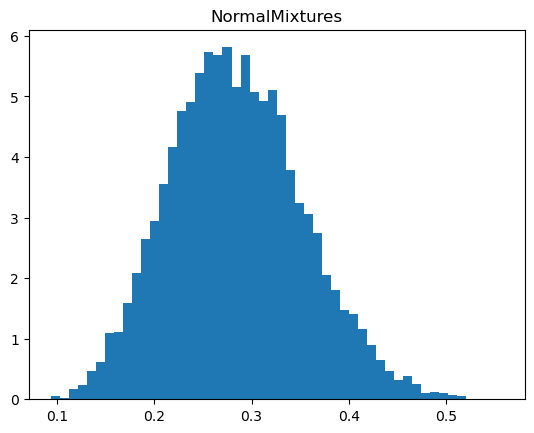

In [11]:
pyro.clear_param_store()

# Data
N = 40  # Number of data points (please adjust this value according to your dataset)
y = torch.tensor([10.0787617156523, -9.51866467444093, 9.73922587306449, 11.5662681883816, 9.62798489000074, -9.60265090119919, 8.90114345923455, 10.866328444034, 10.5347883361026, 8.60577222463504, -10.625227428575, -9.08615131315038, -8.99280046532217, 9.43533905966944, 8.92696803962787, 9.642301288006, 9.42066621557773, 9.90838406119759, 9.63911912487384, 7.55585122379505, 9.58069898235901, 9.63228461457187, -9.99589804304319, 8.61024296515084, -10.4988882191036, -8.45028703711596, 9.76066425342707, -8.68129886943495, 9.83763492226261, 7.29698608457303, 8.78881675784227, 10.6057117460834, 10.2807363791435, 9.54352982843898, -10.9911972452721, 12.2061931600758, 7.76887153466896, 10.7523541087606, -9.98525551020183, 10.6248182699128])  

# Define the Pyro model
def model(N, y):
    theta = pyro.sample("theta", dist.Uniform(0.,1.))  # Beta distribution with alpha=1, beta=1
    mu1 = pyro.sample("mu1", dist.Normal(-10.,1.))
    mu2 = pyro.sample("mu2", dist.Normal(10.,1.))
    
    for n in pyro.plate("data", N):
        comp = pyro.sample("comp{}".format(n), dist.Bernoulli(theta))
        prob = torch.where(comp.bool(), mu2, mu1)  
        pyro.sample("obs{}".format(n), dist.Normal(prob, 1.0), obs=y[n])
        
mcmc_samples = mcmc(model, 'theta', args=(N,y), num_samples=10000, plot_title='NormalMixtures')

In [12]:
pyro.clear_param_store()

# Data
N = 40  # Number of data points (please adjust this value according to your dataset)
y = torch.tensor([10.0787617156523, -9.51866467444093, 9.73922587306449, 11.5662681883816, 9.62798489000074, -9.60265090119919, 8.90114345923455, 10.866328444034, 10.5347883361026, 8.60577222463504, -10.625227428575, -9.08615131315038, -8.99280046532217, 9.43533905966944, 8.92696803962787, 9.642301288006, 9.42066621557773, 9.90838406119759, 9.63911912487384, 7.55585122379505, 9.58069898235901, 9.63228461457187, -9.99589804304319, 8.61024296515084, -10.4988882191036, -8.45028703711596, 9.76066425342707, -8.68129886943495, 9.83763492226261, 7.29698608457303, 8.78881675784227, 10.6057117460834, 10.2807363791435, 9.54352982843898, -10.9911972452721, 12.2061931600758, 7.76887153466896, 10.7523541087606, -9.98525551020183, 10.6248182699128])  

# Define the Pyro model
def model(N, y):
    theta = pyro.sample("theta", dist.Uniform(0.,1.))  # Beta distribution with alpha=1, beta=1
    mu1 = pyro.sample("mu1", dist.Normal(-10.,1.))
    mu2 = pyro.sample("mu2", dist.Normal(10.,1.))
    
    for n in pyro.plate("data", N):
        comp = pyro.sample("comp{}".format(n), dist.Bernoulli(theta))
        prob = torch.where(comp.bool(), mu1, mu2)  
        pyro.sample("obs{}".format(n), dist.Normal(prob, 1.0), obs=y[n])
        
def guide(N, y):
    
    theta_map = pyro.param('theta_map', torch.tensor(0.5), constraint=constraints.unit_interval)
    theta = pyro.sample("theta", dist.Delta(theta_map)) 
    
    mu1 = pyro.sample("mu1", dist.Normal(-10.,1.))
    mu2 = pyro.sample("mu2", dist.Normal(10.,1.))
    
    for n in pyro.plate("data", N):
        comp = pyro.sample("comp{}".format(n), dist.Bernoulli(theta))
        prob = torch.where(comp.bool(), mu1, mu2)  
        

test(model, guide, 'theta', args=(N,y))

Learning rate:  0.01
Performed 1100 steps
Computed in: 49.479
Estimated value: 0.23620811104774475
________________________________
Learning rate:  0.005
Performed 300 steps
Computed in: 14.982
Estimated value: 0.47711676359176636
________________________________
Learning rate:  0.001
Performed 200 steps
Computed in: 9.716
Estimated value: 0.4997936189174652
________________________________


{0.01: 0.23620811104774475,
 0.005: 0.47711676359176636,
 0.001: 0.4997936189174652}

# TimeSeries

Sample: 100%|█████████████████████████████████████| 10500/10500 [39:30,  4.43it/s, step size=1.96e-01, acc. prob=0.944]


MAP value in: -1.5423712 -1.5217392
Mean value: -1.5740857


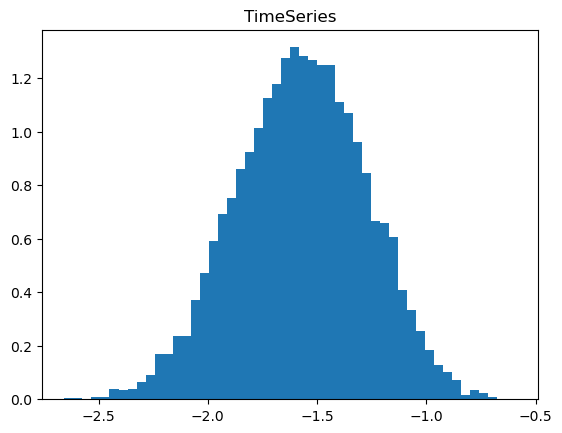

In [6]:
def model(T, y, x):
    alpha = pyro.sample("alpha", dist.Uniform(-5, 5))
    beta = pyro.sample("beta", dist.Uniform(-5, 5))
    lambda_ = pyro.sample("lambda", dist.Uniform(0, 1))
    
    for i in pyro.plate('obs', T-1):
        pyro.sample("y{}".format(i+1), dist.Normal(alpha + beta *x[i+1] + lambda_ *obs_y[i], 0.5), obs=obs_y[i+1])

mcmc_samples = mcmc(model, 'alpha', args=(T,y,x), num_samples=10000, plot_title='TimeSeries')

In [15]:
# Data
T = 40  # Number of time points
x = torch.tensor([0.0530897649405518, -0.427176340746955, 0.575506045064776, -1.05503057032362, -0.00138425373659317, 0.362367184144129, -0.906400668762085, 1.39464604836768, -1.40047244298115, -0.872458836353285, -0.425555167755021, -0.192907289991263, 0.611345320709905, 0.223493915844394, -0.335855643300744, -0.786177511979181, 1.0466888412128, -1.35578280849525, -0.4802662607177, -0.482825573577857, -0.44808934155094, 1.41677018342172, -1.12722529948411, -1.52518755310289, -0.232336215009525, -0.452482201859223, -0.235580964484178, -0.789514125170731, 1.61944620303219, 0.735756130006795, -1.0253656503392, 0.936124304383727, 1.10587169595422, 0.833182124741184, 0.113696178051401, -1.15636049024915, 1.85507312756962, 1.30957252757083, 0.822235075588577, -1.43800316565635]) 
y = torch.tensor([-1.09070023335653, -2.49513228748069, -2.07918898737732, -3.34621083464711, -3.21905761756761, -3.84835139936697, -4.14591579938845, -2.17085702918779, -2.72986009710348, -2.35417403593087, -3.05798313015489, -2.85360404455837, -2.9261492993768, -2.67713444957349, -2.97731974867721, -4.7510500052692, -3.2939903406896, -4.11626048191435, -4.08086402479665, -3.34743297842617, -3.59294970060833, -1.70489370379594, -3.522911840642, -4.13944648650588, -4.04992280586435, -3.71707285571859, -2.6830205191276, -3.21920265745786, -1.78221835462429, -1.71385611701893, -3.15284681754168, -3.26094915407183, -2.92240028325557, -2.40186352631743, -3.1697331801915, -4.00540748111558, -2.32625323220302, -1.74827635320394, -1.05716214917384, -3.44536781268663]) 
obs_y = torch.tensor([-1.09070023335653, -2.49513228748069, -2.07918898737732, -3.34621083464711, -3.21905761756761, -3.84835139936697, -4.14591579938845, -2.17085702918779, -2.72986009710348, -2.35417403593087, -3.05798313015489, -2.85360404455837, -2.9261492993768, -2.67713444957349, -2.97731974867721, -4.7510500052692, -3.2939903406896, -4.11626048191435, -4.08086402479665, -3.34743297842617, -3.59294970060833, -1.70489370379594, -3.522911840642, -4.13944648650588, -4.04992280586435, -3.71707285571859, -2.6830205191276, -3.21920265745786, -1.78221835462429, -1.71385611701893, -3.15284681754168, -3.26094915407183, -2.92240028325557, -2.40186352631743, -3.1697331801915, -4.00540748111558, -2.32625323220302, -1.74827635320394, -1.05716214917384, -3.44536781268663]) 

# Define the Pyro model
def model(T, y, x):
    alpha = pyro.sample("alpha", dist.Uniform(-5, 5))
    beta = pyro.sample("beta", dist.Uniform(-5, 5))
    lambda_ = pyro.sample("lambda", dist.Uniform(0, 1))
    
    for i in pyro.plate('obs', T-1):
        pyro.sample("y{}".format(i+1), dist.Normal(alpha + beta *x[i+1] + lambda_ *obs_y[i], 0.5), obs=obs_y[i+1])

def guide(T, y, x):
    alpha_map = pyro.param('alpha_map', torch.tensor(0.))
    alpha = pyro.sample("alpha", dist.Delta(alpha_map))
    beta = pyro.sample("beta", dist.Uniform(-5, 5))
    lambda_ = pyro.sample("lambda", dist.Uniform(0, 1))
    

res = test(model, guide, 'alpha', args=(T, y, x))

Learning rate:  0.01
Performed 3100 steps
Computed in: 55.367
Estimated value: -1.5639817714691162
________________________________
Learning rate:  0.005
Performed 1100 steps
Computed in: 26.637
Estimated value: -1.4970028400421143
________________________________
Learning rate:  0.001
Performed 2800 steps
Computed in: 75.413
Estimated value: -1.3473550081253052
________________________________
